In [1]:
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm


# get_ipython().run_line_magic('matplotlib', 'qt5')

def time_to_maturity(t0, T, y=252):
    t0 = np.datetime64(t0)
    T = np.datetime64(T)
    return (np.busday_count(t0, T) / y)

ttm = time_to_maturity('2019-03-29', '2019-04-10')
print(ttm)

0.031746031746031744


In [2]:
def bsm_price(option_type, sigma, s, k, r, ttm, q):
    # calculate the bsm price of European call and put options
    sigma = float(sigma)
    d1 = (np.log(s / k) + (r - q + sigma ** 2 * 0.5) * ttm) / (sigma * np.sqrt(ttm))
    d2 = d1 - sigma * np.sqrt(ttm)
    if option_type == 'c':
        price = np.exp(-r*ttm) * (s * np.exp((r - q)*ttm) * stats.norm.cdf(d1) - k *  stats.norm.cdf(d2))
        return price
    elif option_type == 'p':
        price = np.exp(-r*ttm) * (k * stats.norm.cdf(-d2) - s * np.exp((r - q)*ttm) *  stats.norm.cdf(-d1))
        return price
    else:
        print('No such option type %s') %option_type
        

def implied_volatility(option_type, option_price, s, k, r, ttm, q):
    
    if np.isnan(option_price):
        return np.nan
    
    else :
        upper_vol = 1
        lower_vol = 0.00001
        mid_vol = (upper_vol + lower_vol)/2.0
        tol = 0.0001
        # Bisection method
        while upper_vol-lower_vol >= tol :
            fa = option_price - bsm_price(option_type, lower_vol, s, k, r, ttm, q)
            fc = option_price - bsm_price(option_type, mid_vol, s, k, r, ttm, q)

            if fa*fc <= 0:
                upper_vol = mid_vol
                lower_vol = lower_vol
            else:
                lower_vol = mid_vol
                upper_vol = upper_vol

            mid_vol = (upper_vol + lower_vol)/2.0

        return mid_vol

## Operation test

In [3]:
import time
startTime = time.time()
iv = implied_volatility(option_type='c',option_price=0.3, s = 3, k = 3, r = 0.017, ttm=30.0/252, q=0.01)
endTime = time.time() - startTime
print('Implied volatility : ', iv)
print('Opration time : ', endTime)

Implied volatility :  0.7265347171020508
Opration time :  0.007498025894165039


Data is obtained from KRX webpage

In [4]:
df = pd.read_csv('190329put.csv', index_col = 'date')
df.head()

,type,strike,mv
date,,,
2019-04-11,P,215.0,0.01
2019-04-11,P,217.5,0.01
2019-04-11,P,220.0,0.01
2019-04-11,P,222.5,0.01
2019-04-11,P,225.0,0.01


## Preparing index & splitting df by index

In [5]:
# sort_of_date : literally sort of date without overlap
# sorting_by_date : a list including dfs splited by sort of dates.

sorting_by_date = []
sort_of_date = df.index.drop_duplicates()

# split dfs along date
for date in sort_of_date:
    sorting_by_date.append(df.loc[date].drop('type', axis=1))

In [6]:
# ex) '2019-04-11' data
sorting_by_date[0].head()
#len(sorting_by_date[10])

,strike,mv
date,,
2019-04-11,215.0,0.01
2019-04-11,217.5,0.01
2019-04-11,220.0,0.01
2019-04-11,222.5,0.01
2019-04-11,225.0,0.01


search the highest length, minimum strike, maximum strike df for grid

In [7]:
tmp_len_list = []
tmp_mink_list = []
tmp_maxk_list = []

for i in range(len(sorting_by_date)):
    length = len(sorting_by_date[i])
    tmp_len_list.append(length)
    
    min_k = min(sorting_by_date[i]['strike'])
    tmp_mink_list.append(min_k)
    
    max_k = max(sorting_by_date[i]['strike'])
    tmp_maxk_list.append(max_k)
    
print(tmp_len_list)
print('min strike: ', min(tmp_mink_list))
print('max strike: ', max(tmp_maxk_list))

[47, 47, 81, 43, 39, 69, 42, 27, 18, 21, 16]
min strike:  195.0
max strike:  400.0


In [8]:
global_min_strike = min(tmp_mink_list)
global_max_strike = max(tmp_maxk_list)

## Inter&extrapolation on data for smoothed surface

In [9]:
from scipy.optimize import curve_fit

def func(x, a, b, c): # extrapolation function
    return a * (x ** 2) + b * x + c


interpolated_strike = np.arange(global_min_strike, global_max_strike+2.5, 2.5) # 2.5 is delta_k

nan_value = np.empty_like(interpolated_strike)
nan_value.fill(np.nan) # ready for mv interpolation

expanded_df = pd.DataFrame(np.concatenate([interpolated_strike.reshape(-1,1), nan_value.reshape(-1,1)], axis=1), 
                               columns=['strike', 'mv'])

interpolated_df_list=[]    
for i in range(len(sorting_by_date)):    
    merged_df = pd.merge_ordered(sorting_by_date[i],expanded_df, on='strike').drop('mv_y', axis=1).rename(columns={'mv_x': 'mv'})
    
    ## interpolation first for stability of extrapolated values
    merged_df.mv.interpolate(method='polynomial', order=2, inplace=True) # interpolation!
    
    ## then, extrapolation process start
    # Initial parameter guess, just to kick off the optimization
    guess = (0.5, 0.5, 0.5)

    # Create copy of data to remove NaNs for curve fitting
    fit_df = merged_df.dropna()

    # Place to store function parameters for each column
    col_params = {}
    
    # Get x & y
    x = fit_df['strike'].values
    y = fit_df['mv'].values
    # Curve fit column and get curve parameters
    params = curve_fit(func, x, y, guess)
    # Store optimized parameters
    col_params['mv'] = params[0]

    # Extrapolate
    ix = merged_df[pd.isnull(merged_df['mv'])].index
    x = merged_df[pd.isnull(merged_df['mv'])]['strike'].values
    # Extrapolate those points with the fitted function
    merged_df['mv'].loc[ix] = func(x, *col_params['mv'])
    
    
    expanded_date=np.empty_like(interpolated_strike, dtype='object') # dtype='object' is important for arbitrary length of str!
    expanded_date.fill(sort_of_date[i])
    merged_df.index = expanded_date # index setting to datetime
    
    interpolated_df_list.append(merged_df)

## Drawing surface

In [11]:
s = 276.48 # 2019.03.28 KOSPI200 close price
r = 0.017 # reference : return of Korea Treasury Bond 3yr

# preparation for grid

ttm_list=[]
for date in sort_of_date:
    ttm_list.append(time_to_maturity('2019-03-29', date))
    
strike_list = interpolated_strike

mv_list=[]

for df in interpolated_df_list:
    mv_list.append(df.mv.values)
mv_mat = np.array(mv_list) # (11, 83)


# Making 3d grid value
'''
x_axis = time to maturity
y_axis = strike price
z_axis = implied volatility
'''

ttm, k = np.meshgrid(ttm_list, strike_list) # (83, 11)
im_vol_matrix = np.zeros_like(ttm)

for i in range(len(ttm_list)): # along with TTM (11)
    ttm_ = ttm_list[i]
    for j in range(len(strike_list)): # along with Strike Price (83)
        k_ = strike_list[j]
        mv_ = mv_mat[i][j]
        im_vol_matrix[j][i] = implied_volatility(option_type='p', option_price=mv_, s = s, k = k_, r = r, ttm=ttm_, q=0.0)
        

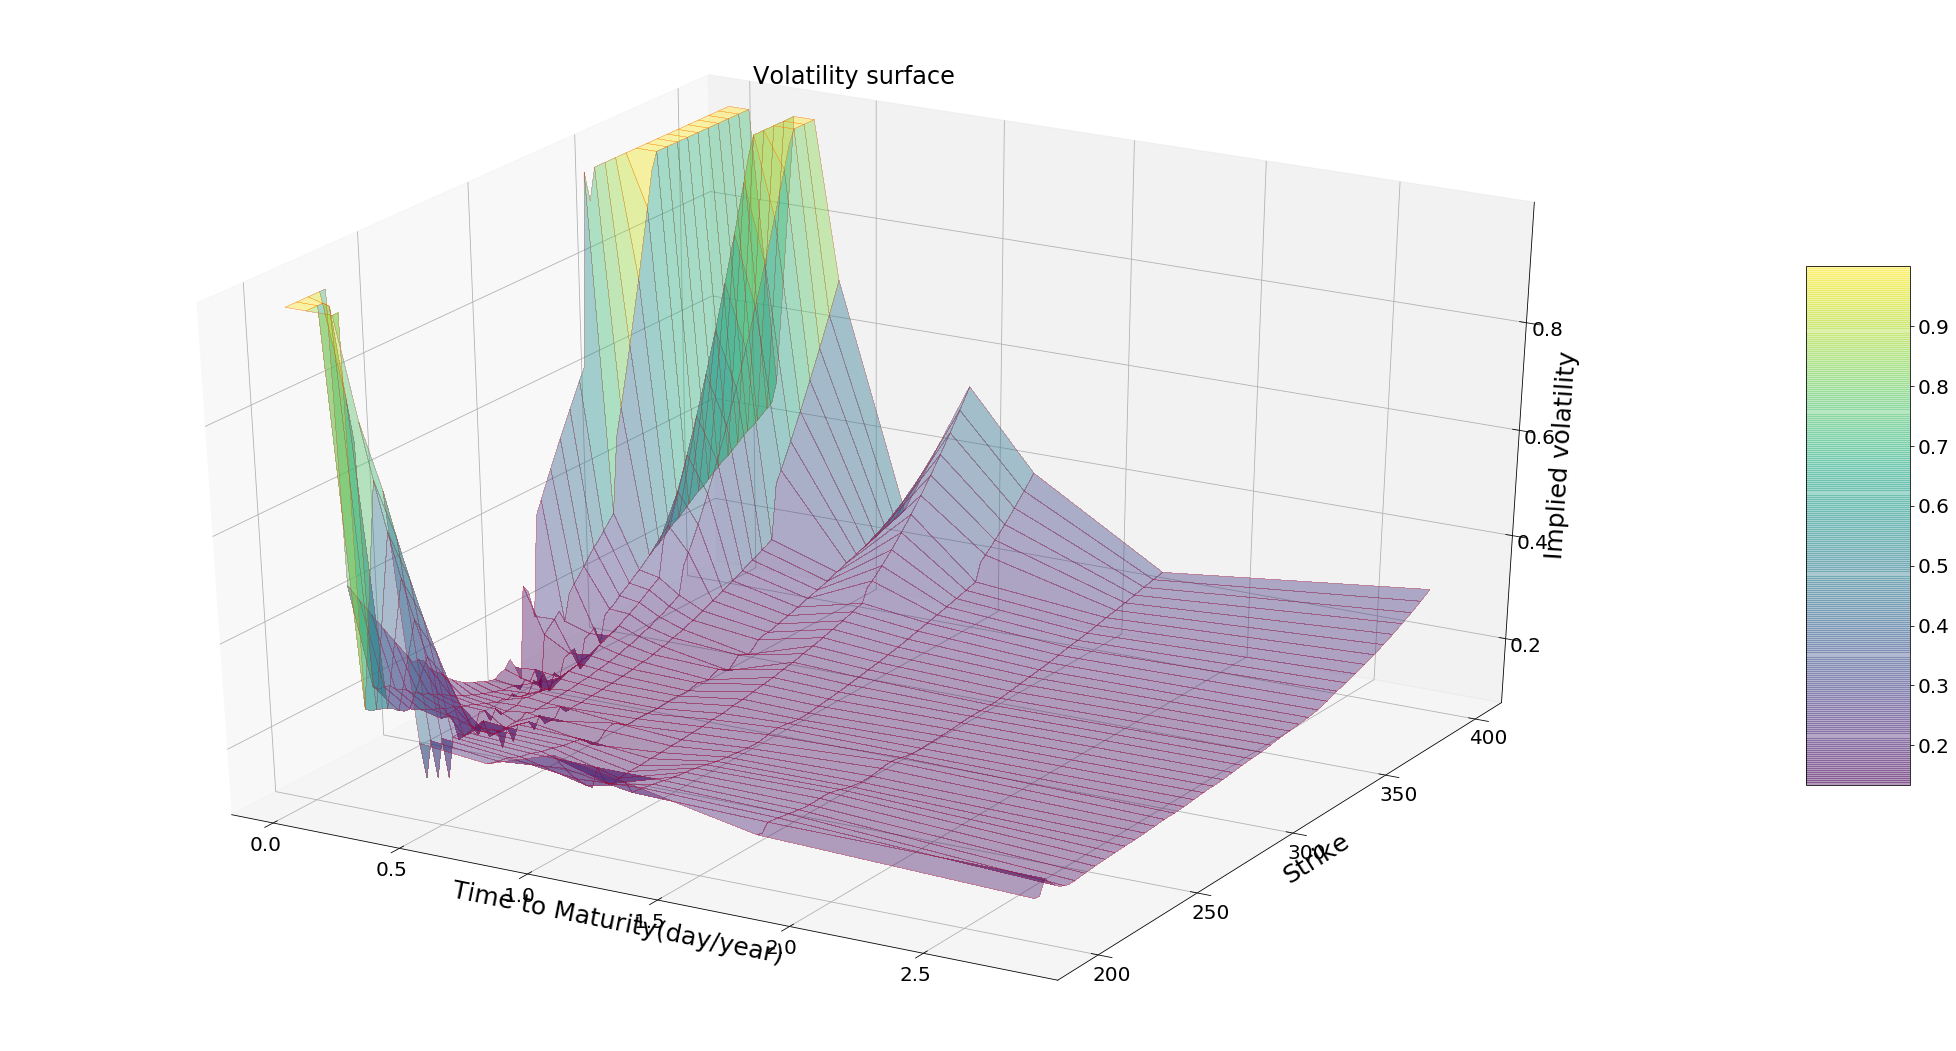

In [19]:
plt.rcParams['figure.figsize'] = [30, 15]
plt.rcParams.update({'font.size': 20})
plt.rc('axes', labelsize = 25)
plt.rc('figure', titlesize = 30)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(ttm, k , im_vol_matrix, cmap='viridis',
                       linewidth=0.5, antialiased=False, alpha=0.4)
wire = ax.plot_wireframe(ttm, k, im_vol_matrix, color='r',linewidth=0.2)

ax.set_xlabel('Time to Maturity(day/year)')
ax.set_ylabel('Strike')
ax.set_zlabel('Implied volatility')
ax.set_title('Volatility surface')

fig.colorbar(surf, shrink=0.5, aspect=5)
fig.tight_layout()
